In [2]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

In [3]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [21]:
@tool
def add(a: int, b: int) -> int:
    """function used to add two numbers"""
    return a + b


@tool
def subtrack(a: int, b: int) -> int:
    """function to subtrack two number and return abs value"""
    return abs(a - b)


@tool
def multiply(a: int, b: int) -> int:
    """function to multiply two numbers"""
    return a * b


tools = [add, subtrack, multiply]

LLM = ChatOllama(model="llama3.1").bind_tools(tools)

In [22]:
def model_call(state: AgentState) -> AgentState:
    """Node respobile for calling the LLM"""

    system_prompt = SystemMessage(
        content="You are my AI assistant, answer the questions to best of you ability"
    )
    response = LLM.invoke([system_prompt] + state["messages"])

    return {"messages": [response]}


def should_contniue(state: AgentState) -> AgentState:
    """Node to determine whether to exit or contniue"""

    last_message = state["messages"][-1]

    if not last_message.tool_calls:
        return "end"

    return "contniue"

In [23]:
tool_node = ToolNode(tools)
graph = StateGraph(AgentState)

graph.add_node("our_agent", model_call)
graph.add_node("tools", tool_node)

graph.add_edge(START, "our_agent")
graph.add_conditional_edges(
    "our_agent", should_contniue, {"contniue": "our_agent", "end": END}
)

graph.add_edge("tools", "our_agent")

agent = graph.compile()

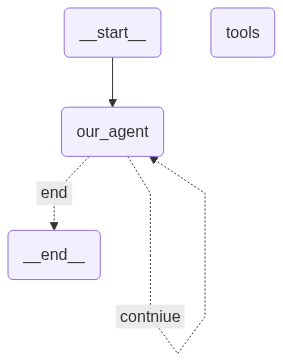

In [24]:
display(Image(agent.get_graph().draw_mermaid_png()))

In [25]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]

        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {
    "messages": [
        (
            "user",
            "Add 2 + 2 and also please add 3 + 5, subtrack 1, 100 and tell me a joke plus multiply 3 * 3",
        )
    ]
}
print_stream(agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 2 + 2 and also please add 3 + 5, subtrack 1, 100 and tell me a joke plus multiply 3 * 3
================================== Ai Message ==================================
Tool Calls:
  add (6af08747-4ccf-4480-9855-5158224694b8)
 Call ID: 6af08747-4ccf-4480-9855-5158224694b8
  Args:
    a: 2
    b: 2
  add (7dee46b5-d6af-4943-8452-9abf5f058876)
 Call ID: 7dee46b5-d6af-4943-8452-9abf5f058876
  Args:
    a: 3
    b: 5
  subtrack (caba1c61-6623-47a5-a83b-ad73c69f072a)
 Call ID: caba1c61-6623-47a5-a83b-ad73c69f072a
  Args:
    a: 1
    b: 100
  multiply (af1d08b8-ff41-4483-9fc1-12b4f2b9649f)
 Call ID: af1d08b8-ff41-4483-9fc1-12b4f2b9649f
  Args:
    a: 3
    b: 3
================================== Ai Message ==================================

 

Based on the tool call responses, here are the results:

- 2 + 2 = 4
- 3 + 5 = 8
- 100 - 1 = 99 
- What do you call a fake noodle? An impasta!
- 3 * 3 = 9
